In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

In [3]:
train_csv = 'dataset/train/_classes.csv'
valid_csv = 'dataset/valid/_classes.csv'
test_csv = 'dataset/test/_classes.csv'
base_dir = 'dataset\\'

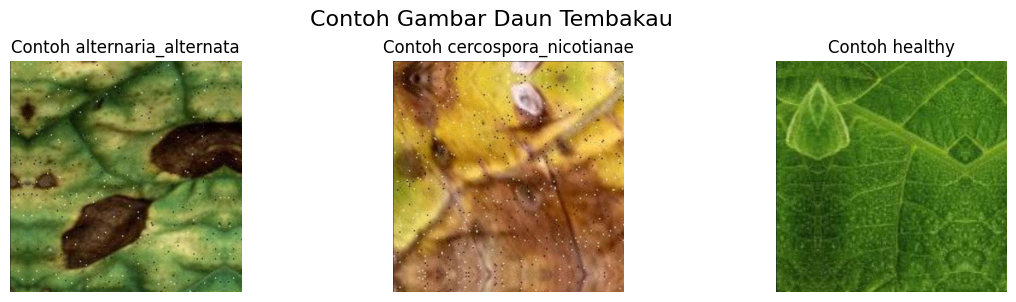

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle('Contoh Gambar Daun Tembakau', fontsize=16, y=1.05)
classes = ['alternaria_alternata', 'cercospora_nicotianae', 'healthy']

for ii, class_name in enumerate(classes):
    dir = f'dataset/train/{class_name}'
    img_path = os.path.join(dir, os.listdir(dir)[0])  # Menggunakan os.path.join untuk keamanan
    img = tf.keras.preprocessing.image.load_img(img_path)
    axes[ii].imshow(img)
    axes[ii].set_title(f'Contoh {class_name}')
    axes[ii].axis('off')

plt.show()

In [5]:
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (640, 640, 3)


In [6]:
sample_array[0,:5]

array([[  0.,  21.,   0.],
       [ 66.,  93.,  38.],
       [ 54.,  83.,  19.],
       [ 62.,  96.,  22.],
       [ 68., 106.,  23.]], dtype=float32)

In [7]:
img_height, img_width = 64, 64
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

In [9]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1051 images belonging to 3 classes.


In [11]:
valid_generator = valid_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 124 images belonging to 3 classes.


In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

c:\laragon\bin\python\Python-3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False  # Membekukan lapisan

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.8236 - loss: 0.4011 - val_accuracy: 0.6979 - val_loss: 0.6412 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9688 - loss: 0.1805 - val_accuracy: 0.8571 - val_loss: 0.4360 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.8323 - loss: 0.4172 - val_accuracy: 0.6979 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7188 - loss: 0.6165 - val_accuracy: 0.7500 - val_loss: 0.6768 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - accuracy: 0.8225 - loss: 0.4176 - val_accuracy: 0.7604 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9062 - loss: 0.2763 - val_accuracy: 0.6071 - val_loss: 0.8275 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.8402 - loss: 0.3815 - v

In [20]:
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 92 images belonging to 3 classes.


In [21]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - accuracy: 0.8542 - loss: 0.5980
Test accuracy: 0.83


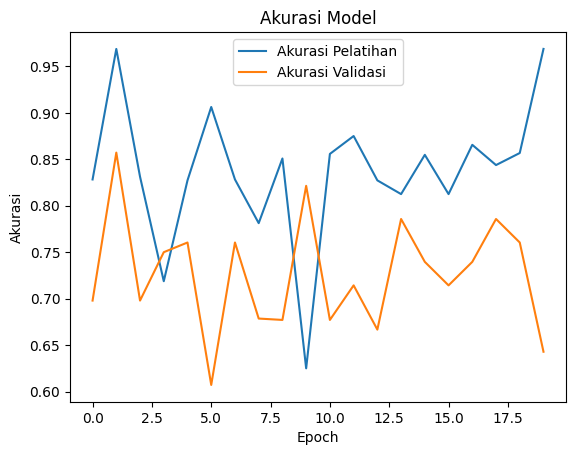

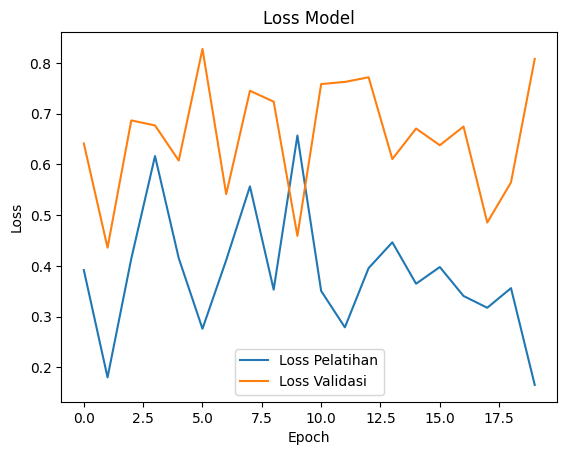

In [22]:
import matplotlib.pyplot as plt

# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
